In [203]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns   

In [204]:
#%pip install -U category_encoders


For this competition, there are two target variables:

- h1n1_vaccine - Whether respondent received H1N1 flu vaccine.

- seasonal_vaccine - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes. Some respondents didn't get either vaccine, others got only one, and some got both. This is formulated as a multilabel (and not multiclass) problem

The features in this dataset

You are provided a dataset with 36 columns. The first column respondent_id is a unique and random identifier. The remaining 35 features are described below.

For all binary variables: 0 = No; 1 = Yes.

- h1n1_concern - Level of concern about the H1N1 flu.
0 = Not at all concerned; 
1 = Not very concerned; 
2 = Somewhat concerned; 
3 = Very concerned.

- h1n1_knowledge - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.

- behavioral_antiviral_meds - Has taken antiviral medications. (binary)

- behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)

- behavioral_face_mask - Has bought a face mask. (binary)

- behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)

- behavioral_large_gatherings - Has reduced time at large gatherings. (binary)

- behavioral_outside_home - Has reduced contact with people outside of own household. (binary)

- behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)

- doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)

- doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)

- chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

- child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
health_worker - Is a healthcare worker. (binary)
health_insurance - Has health insurance. (binary)
opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

- opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

- opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

- opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

- opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

- opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

- age_group - Age group of respondent.

- education - Self-reported education level.

- race - Race of respondent.

- sex - Sex of respondent.

- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.

- marital_status - Marital status of respondent.

- rent_or_own - Housing situation of respondent.

- employment_status - Employment status of respondent.

- hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

- household_adults - Number of other adults in household, top-coded to 3.

- household_children - Number of children in household, top-coded to 3.

- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.

- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.



In [205]:
submission_format = pd.read_csv('submission_format.csv')  
submission_format.head(3)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.5,0.7
1,26708,0.5,0.7
2,26709,0.5,0.7


submission_format в целом для нас как я понял это бесполезный файл, с ним работать не прийдется. Это файл пример для сдачи как я понял

In [206]:
training_set_features = pd.read_csv('training_set_features.csv')  
training_set_labels = pd.read_csv('training_set_labels.csv')  
print(len(training_set_features), len(training_set_labels))
len_tr_set = len(training_set_features)

26707 26707


In [207]:
training_set_features.head(3)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [208]:
training_set_labels.head(3)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0


In [209]:
training_set_labels.isna().sum()

respondent_id       0
h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

In [210]:
training_set_features.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

явно видно что у нас большое количество фичей с Nan значениеми, так что надо от них избавиться

In [211]:
for i in training_set_features.columns:
    t = training_set_features[i].isna().sum() / len_tr_set
    if t < 0.03: 
        print(f"{i} ---- 1 ---- {training_set_features[i].isna().sum() / len_tr_set:.3f}%")
    elif t < 0.1:
        print(f"{i} ---- 2 ---- {training_set_features[i].isna().sum() / len_tr_set:.3f}%")
    else:
        print(f"{i} ---- 3 ---- {training_set_features[i].isna().sum() / len_tr_set:.3f}% !!!!!!!!!!!!")

respondent_id ---- 1 ---- 0.000%
h1n1_concern ---- 1 ---- 0.003%
h1n1_knowledge ---- 1 ---- 0.004%
behavioral_antiviral_meds ---- 1 ---- 0.003%
behavioral_avoidance ---- 1 ---- 0.008%
behavioral_face_mask ---- 1 ---- 0.001%
behavioral_wash_hands ---- 1 ---- 0.002%
behavioral_large_gatherings ---- 1 ---- 0.003%
behavioral_outside_home ---- 1 ---- 0.003%
behavioral_touch_face ---- 1 ---- 0.005%
doctor_recc_h1n1 ---- 2 ---- 0.081%
doctor_recc_seasonal ---- 2 ---- 0.081%
chronic_med_condition ---- 2 ---- 0.036%
child_under_6_months ---- 2 ---- 0.031%
health_worker ---- 2 ---- 0.030%
health_insurance ---- 3 ---- 0.460% !!!!!!!!!!!!
opinion_h1n1_vacc_effective ---- 1 ---- 0.015%
opinion_h1n1_risk ---- 1 ---- 0.015%
opinion_h1n1_sick_from_vacc ---- 1 ---- 0.015%
opinion_seas_vacc_effective ---- 1 ---- 0.017%
opinion_seas_risk ---- 1 ---- 0.019%
opinion_seas_sick_from_vacc ---- 1 ---- 0.020%
age_group ---- 1 ---- 0.000%
education ---- 2 ---- 0.053%
race ---- 1 ---- 0.000%
sex ---- 1 ---- 0.000

employment_occupation и employment_industry, health_insurance  тк у них +- 50% Nan я удаляю

In [212]:
df = pd.merge(training_set_features, training_set_labels, on='respondent_id', how='inner')
df.head(5)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [213]:
df = df.drop(columns=['employment_occupation', 'employment_industry', 'health_insurance'])
df.head(3)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0


In [214]:
bin_cols = [
    'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
    'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
    'chronic_med_condition', 'child_under_6_months', 'health_worker'
]
cat_cols = [
    'age_group', 'education', 'race', 'sex', 'income_poverty',
    'marital_status', 'rent_or_own', 'employment_status',
    'hhs_geo_region', 'census_msa','h1n1_concern', 'h1n1_knowledge',
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'
]

num_cols = ['household_adults', 'household_children']

In [220]:
df['h1n1_vaccine'].value_counts()

h1n1_vaccine
0    21033
1     5674
Name: count, dtype: int64

In [215]:
# Бинарные: заполним NaN отдельной категорией -1 (unknown)
for c in bin_cols:
    if c in df.columns:
        df[c] = df[c].astype("float")
        df[c] = df[c].fillna(-1).astype("int8")  # уровни: -1 unknown, 0, 1

# Категориальные с малым процентом пропусков (<10%)
from sklearn.impute import SimpleImputer
for col in cat_cols:
    if df[col].isna().sum() / len(df) < 0.1:
        imputer = SimpleImputer(strategy='most_frequent')
        df[col] = imputer.fit_transform(df[[col]]).ravel()

# Категориальные с большим процентом пропусков (>10%)
for col in cat_cols:
    if df[col].isna().sum() / len(df) >= 0.1:
        df[col] = df[col].fillna('Unknown')

# работает с числовыми признаками
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [216]:
df.isna().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

Дата сет более менее очистил, теперь можно приступать к анализу данных

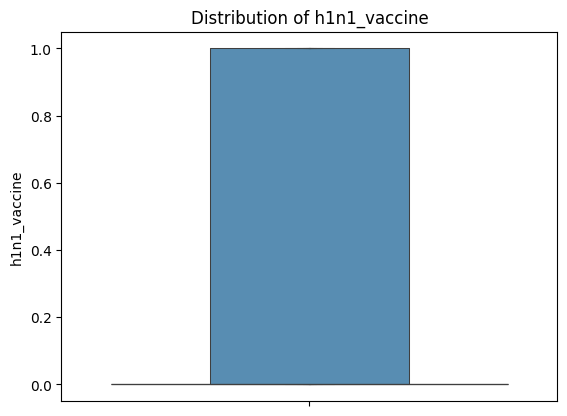

In [217]:
sns.boxenplot(data=df['h1n1_vaccine'])
plt.title("Distribution of h1n1_vaccine")
plt.xlabel("")
plt.ylabel("h1n1_vaccine")
plt.show()

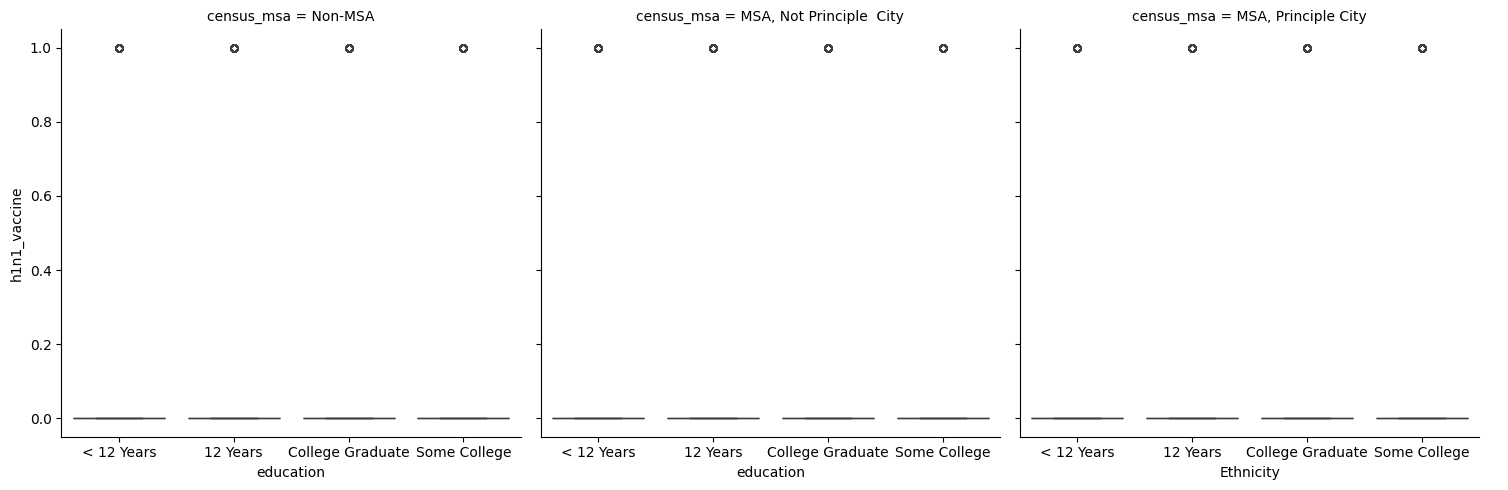

In [222]:
sns.catplot(
    data=df,
    kind="box",
    x="education",       
    y="h1n1_vaccine",
    col= 'census_msa'          
)
plt.xlabel("Ethnicity")
plt.ylabel("Income")
plt.show()

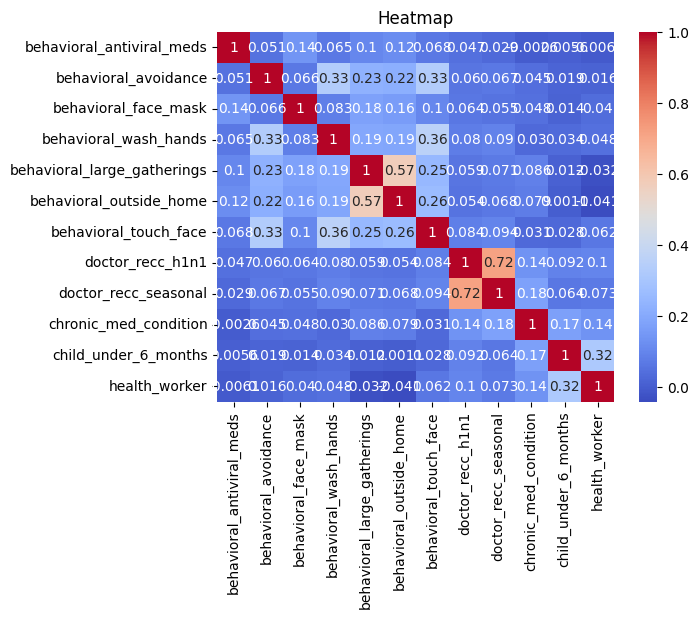

In [224]:
df_selected = df[bin_cols]
corr_matrix = df_selected.corr(method='kendall')

sns.heatmap(corr_matrix, annot = True, cmap='coolwarm')
plt.title('Heatmap')
plt.show()

Ну как я понял тут все признаки категориальные, просто некоторые из них бинарные а остальные не бинарные. Так что я небинарные признаки занесу в отдельную колонку